# Digits dataset

The purpose of this notebook is to display how to apply different machine learning models to the toy data set **Digits Dataset**.

http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html

In [1]:
%matplotlib inline
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression

# Load data set

In [2]:
digits = load_digits()

There are 1797 images (8 by 8 pixels each) ranging from 0 to 9.

In [3]:
print('x: {}'.format(digits.data.shape))
print('y: {}'.format(digits.target.shape))

x: (1797, 64)
y: (1797,)


## Display data set

In [4]:
n_images = 5

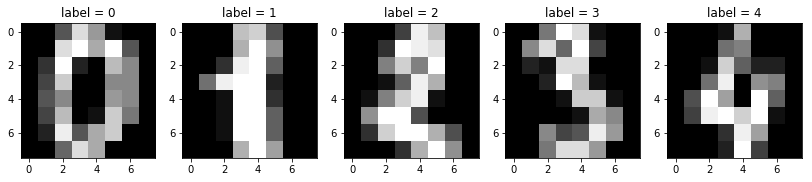

In [5]:
fig, ax = plt.subplots(1, n_images, figsize=(14, 4))

for idx, (x, y) in enumerate(zip(digits.data[:n_images], digits.target[:n_images])):
    x_image = np.reshape(x, (8, 8))
    
    ax[idx].imshow(x_image, cmap=plt.cm.gray)
    ax[idx].set_title('label = {}'.format(y))
    ax[idx].grid(False)

## Distribution

x ranges from 0 to 16. Most pixels are zero.

In [6]:
x_concat = pd.DataFrame(reduce(lambda x, y: np.concatenate((x, y)), digits.data), 
                        columns=['x']).astype(int)

In [7]:
x_concat.describe()

,x
count,115008.000000
mean,4.884165
std,6.016814
min,0.000000
25%,0.000000
50%,1.000000
75%,10.000000
max,16.000000


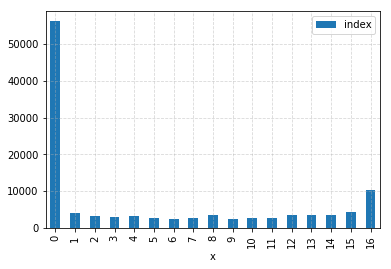

In [8]:
x_concat.reset_index().groupby('x').count().plot(kind='bar');

## Train test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, 
                                                    test_size=0.25, random_state=0)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1347, 64)
(1347,)
(450, 64)
(450,)


# Logistic regression
## fit
For multi-class logistic regression, the one-vs-rest (`multi_class='ovr'`) algorithm is used, which will end up creating k different binary models.
$$
p \left( y=k \mid X, \beta \right) = 
\hat{y}^{\left( k \right)} \left( X \right) = 
\frac{1}{1 + e^{-X \beta^{\left( k \right)}}} \\
\hat{y}\left( X \right) = \max_{k} \hat{y}^{\left( k \right)} \left( X \right)
$$

In [11]:
lr = LogisticRegression()

In [12]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
lr.coef_.shape

(10, 64)

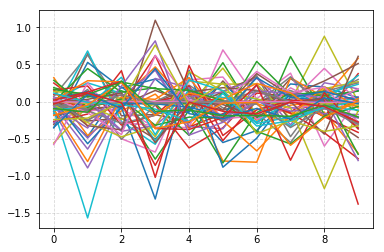

In [14]:
plt.plot(lr.coef_);

## predict

In [15]:
print(lr.predict(x_train[[0]])[0])
print(y_train[0])

2
2


## score

The `score` method is based on accuracy.

In [16]:
lr.score(x_train, y_train)

0.99628804751299183

In [17]:
lr.score(x_test, y_test)

0.95333333333333337

## confusion matrix
The confusion matrix shows how each label is classified. A good model should have higher numbers on diagonal elements while off-diagonals contain smaller numbers.

In [18]:
lr_cm = confusion_matrix(y_test, lr.predict(x_test))

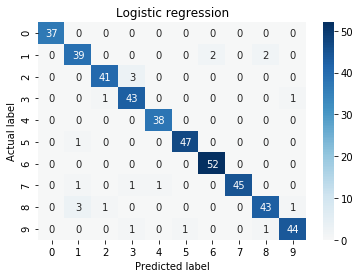

In [19]:
fig, ax = plt.subplots()
sns.heatmap(lr_cm, annot=True, cmap='RdBu', center=0, ax=ax)
ax.set_title('Logistic regression')
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label');

# Random forest classifier
The default number of trees is 10 (`n_estimators` = 10)

## cross-validation

In [20]:
def plot_grid_search_cv_result(grid_result):
    params = grid_result.cv_results_['params']
    means = pd.DataFrame(grid_result.cv_results_['mean_test_score'], 
                         index=params, columns=['score'])
    stds = pd.Series(grid_result.cv_results_['std_test_score'], index=params)
    means.plot(kind='barh', xerr=stds)

In [21]:
rf_param_grid = {
    'n_estimators': [10, 100, 1000]
}

In [22]:
rf_base_model = RandomForestClassifier()
rf_cv = KFold(n_splits=10)

rf_grid_search = GridSearchCV(
    estimator=rf_base_model,
    param_grid=rf_param_grid,
    cv=rf_cv,
    return_train_score=False
)

In [23]:
rf_grid_result = rf_grid_search.fit(x_train, y_train)

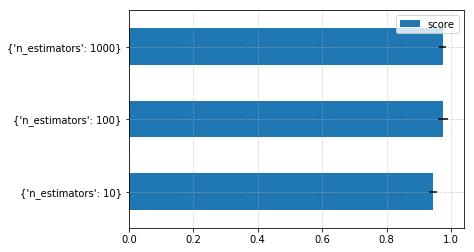

In [24]:
plot_grid_search_cv_result(rf_grid_result)

## fit

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [26]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## score

In [27]:
rf.score(x_train, y_train)

1.0

In [28]:
rf.score(x_test, y_test)

0.97555555555555551

## confusion matrix

In [29]:
rf_cm = confusion_matrix(y_test, rf.predict(x_test))

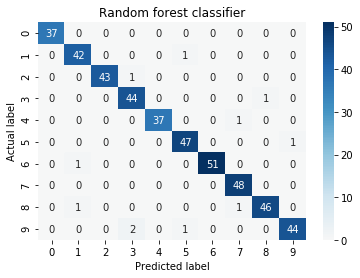

In [30]:
fig, ax = plt.subplots()
sns.heatmap(rf_cm, annot=True, cmap='RdBu', center=0, ax=ax)
ax.set_title('Random forest classifier')
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label');